<a href="https://colab.research.google.com/github/myselfdk03/ml-model/blob/main/PINN_burger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### PINN for Burger equation


## What are PINNs
PINNs are neural network that incoorporates physical laws described by PDEs into the learning process. Unlike traditional neural network that rely purely on data, PINNs lenerage the governing equations of the system to inform the training process. This integration ensures that the prediction of the network adhere to known physical principles, leading to more accurate results even with limited data.

# Problem Definition
We will solve the following 1D Burger equation:
$\frac{\delta u}{\delta t} + u \frac{\delta u}{\delta x} = v \frac{\delta^2 u}{\delta u^2}$ \\
$x \in [-1, 1], t \in [0,1] $ \\

with the dirichlet boundary conditions and initial conditions: \\
$u(-1, t) = u(1,t) = 0, u(x,0)=-sin(\pi x)$ \\
where: \\



*   $u$ is the solution as a function of space and time, $u(x,t)$
*   $v$ is the viscosity coefficient, which controls the smoothness of the solution, it is considered as $0.01/\pi$




In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# load reference data
data = np.load('/content/drive/MyDrive/Burgers (2).npz')

In [ ]:
print(data.files)

['t', 'x', 'usol']


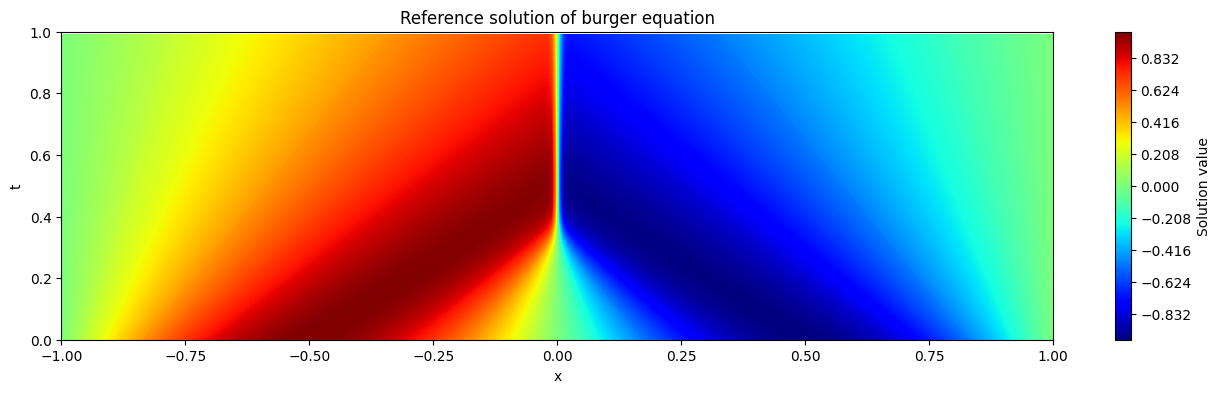

In [ ]:
t_ref, x_ref, exact = data['t'], data['x'], data['usol'].T

# reshape x_ref adn t_ref to match the shape of exact
x_ref, t_ref = np.meshgrid(x_ref, t_ref)

# Define the plot range for x and t
x_min, x_max = -1, 1
t_min, t_max = 0, 1

# Create the contour plot
plt.figure(figsize=(16, 4))
contour = plt.contourf(x_ref, t_ref, exact, levels=250, cmap='jet')
plt.colorbar(contour, label='Solution value')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Reference solution of burger equation')
plt.xlim(x_min, x_max)
plt.ylim(t_min, t_max)
plt.show()

In [ ]:
t_ref

array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       [0.02, 0.02, 0.02, ..., 0.02, 0.02, 0.02],
       ...,
       [0.97, 0.97, 0.97, ..., 0.97, 0.97, 0.97],
       [0.98, 0.98, 0.98, ..., 0.98, 0.98, 0.98],
       [0.99, 0.99, 0.99, ..., 0.99, 0.99, 0.99]])

In [ ]:
x_ref

array([[-1.        , -0.99215686, -0.98431373, ...,  0.98431373,
         0.99215686,  1.        ],
       [-1.        , -0.99215686, -0.98431373, ...,  0.98431373,
         0.99215686,  1.        ],
       [-1.        , -0.99215686, -0.98431373, ...,  0.98431373,
         0.99215686,  1.        ],
       ...,
       [-1.        , -0.99215686, -0.98431373, ...,  0.98431373,
         0.99215686,  1.        ],
       [-1.        , -0.99215686, -0.98431373, ...,  0.98431373,
         0.99215686,  1.        ],
       [-1.        , -0.99215686, -0.98431373, ...,  0.98431373,
         0.99215686,  1.        ]])

##  mathematical formulation of the Loss Function

The total loss function $L_{total}$ for solving the Burgers' equation using PINNs combines three key loss components:

1. Initial condition loss $L_{IC}$
the initial condition loss for burger equation $(u(x,0) = -sin(\pi x)
  \forall x \in [-1,1]  $ is defined as: \\

  $u_{NN}(x,0) = -sin(\pi x) x \in [-1,1]$ \\

  The initial condition loss measures the discrepancy between the neural network prediction $u_{NN}(x,0)$ and the initial condition $u_{IC}(x)$.

  Mathematically, the initial condition loss $L_{IC}$ is defined as the mean squared error: \\

  $L_{IC}= \frac{1}{N} \sum{i=1}{N} (u_{NN}(x_i,0) - u_{IC}(x_i))^2$,

  where:


*   $N_x$ is the number of spatial points used to evaluate the initial condition.
*   $u_{NN}(x_i,0)$ is the predicted value of $u_{NN} $ at $x=x_i$ and t=0.
*  $u_{IC} =-sin(\pi x)$ is the initial condition at $x=x_i$.

This term ensures that the neural network satisfies the given initial condition at $t=0$.

2.



## Collpcation Points
Collocation pointa are specific locations within the domain where the differential equation and the boundary conditions, and the Burgers' equation across the entire domain. By minimizing this total loss, the neural network approximates the solution $u_{NN}(x,t)$ of the Burgers' equation in PINNs

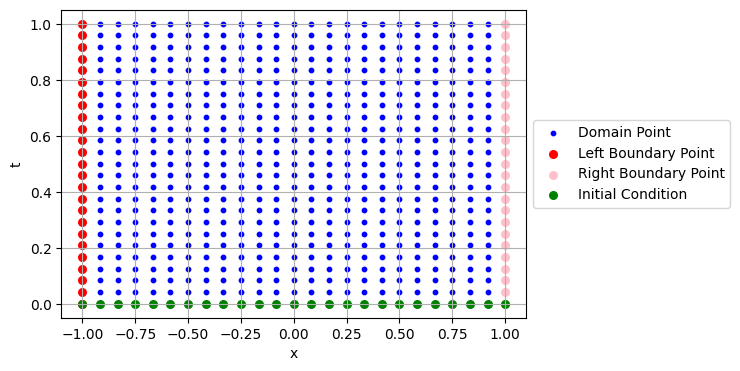

In [ ]:
# spatial points and temporal ppoints
x_values = torch.linspace(-1, 1, 25).view(-1,1)
t_values = torch.linspace(0, 1, 25).view(-1,1)

x_collocation, t_collocation = torch.meshgrid(x_values.squeeze(), t_values.squeeze(), indexing ="xy")
x_collocation = x_collocation.reshape(-1,1)
t_collocation = t_collocation.reshape(-1,1)

#  extract booundary points
x_boundary_left = torch.full_like(t_values, -1.0)
x_boundary_right = torch.full_like(t_values, 1.0)
t_boundary = t_values

# extract inital condition points
x_initial_condition = x_values
t_initial_condition = torch.zeros_like(x_values)

# convert tensors to numpy array for plotting
x_collocation_np = x_collocation.numpy()
t_collocation_np = t_collocation.numpy()

x_boundary_left_np = x_boundary_left.numpy()
x_boundary_right_np = x_boundary_right.numpy()
t_boundary_np = t_boundary.numpy()

x_initial_condition_np = x_initial_condition.numpy()
t_initial_condition_np = t_initial_condition.numpy()

# plot
plt.figure(figsize=(6,4))
plt.scatter(x_collocation_np, t_collocation_np, color='blue', label='Domain Point' , s=10)
plt.scatter(x_boundary_left_np, t_boundary_np, color='red', label='Left Boundary Point' , s=30)
plt.scatter(x_boundary_right_np, t_boundary_np, color='pink', label='Right Boundary Point' , s=30)
plt.scatter(x_initial_condition_np, t_initial_condition_np, color='green', label='Initial Condition' , s=30)
plt.xlabel('x')
plt.ylabel('t')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

# difference between view and reshape

view is used when data is contiguous in memory and reshape is when the data is contiguous or non-contiguous in memory

In [ ]:
x_values.shape

torch.Size([25, 1])

In [ ]:
t_values.shape

torch.Size([25, 1])

## Implementation Steps
1. Step up the Network architecture
2. Define the loss function
3. Train the model
4. Evaluate the results

In [ ]:
model= nn.Sequential(
    nn.Linear(2,20),
    nn.Tanh(),
    nn.Linear(20,20),
    nn.Tanh(),
    nn.Linear(20,20),
    nn.Tanh(),
    nn.Linear(20,20), nn.Tanh(),
    nn.Linear(20,1))

In [ ]:
def forward(x,t):
  inputs = torch.cat((x,t), dim=1)
  return model(inputs)

In [ ]:
# define PDE residual
def pde_residual(x,t,model, nu=0.01):
  x.requires_grad = True
  t.requires_grad = True

  u = forward(x,t)
  u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
  u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
  u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]

  residual = u_t + u*u_x - nu/(np.pi)*u_xx
  return residual

def initial_condition(x):
  return -torch.sin(np.pi*x)

def boundary_condition(x,t):
  return torch.zeros_like(t)

In [ ]:
x = torch.linspace(-1,1,100).view(-1,1)
t = torch.linspace(0,1,100).view(-1,1)

x_train, t_train = torch.meshgrid(x.squeeze(),t.squeeze(), indexing='xy')
x_train = x_train.reshape(-1,1)
t_train = t_train.reshape(-1,1)

In [ ]:
# define model, optimizer and loss function
optimizer = optim.Adam(model.parameters(),lr=0.001)


In [ ]:
# training loop
num_epochs = 12000
for epoch in range(num_epochs):
  model.train()

  # compute initial loss
  input_ic = torch.cat([x,torch.zeros_like(x)], dim=1)
  u_pred = model(input_ic)
  u_true = initial_condition(x)
  loss_ic = torch.mean((u_pred - u_true)**2)


  # compute boundary condition loss
  input_left = torch.cat([torch.full_like(t,-1),t], dim=1)
  input_right = torch.cat([torch.full_like(t,1),t], dim=1)
  u_pred_left = model(input_left) #u(-1,t)
  u_pred_right = model(input_right) #u(1,t)
  loss_bc = torch.mean((u_pred_left - boundary_condition(torch.full_like(x,-1),t))**2 + (u_pred_right - boundary_condition(torch.full_like(x,1),t))**2)

  # compute pde residual loss
  residual = pde_residual(x_train, t_train, model)
  loss_pde = torch.mean(residual**2)

  # compute total loss
  loss = loss_ic + loss_bc + loss_pde

  # backwaed and optimize
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if (epoch+1)%1000 == 0:
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1000/12000], Loss: 0.1170
Epoch [2000/12000], Loss: 0.0901
Epoch [3000/12000], Loss: 0.0287
Epoch [4000/12000], Loss: 0.0160
Epoch [5000/12000], Loss: 0.0079
Epoch [6000/12000], Loss: 0.0055
Epoch [7000/12000], Loss: 0.0039
Epoch [8000/12000], Loss: 0.0030
Epoch [9000/12000], Loss: 0.0025
Epoch [10000/12000], Loss: 0.0022
Epoch [11000/12000], Loss: 0.0022
Epoch [12000/12000], Loss: 0.0022


In [ ]:
# evaluate the model on a grid